In [19]:
import numpy as np
import pandas as pd
import utm
import math
import pickle
import os
import sys
sys.path.append('./src')
import time
import datetime
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import copy
import plot
import split, uni_hmm, pygrid, tools
from data_cleaning import noise, load, counter

In [390]:
load = reload(load)
dataset = 'siping'
datatype = '2g'
data_file = './data/%s_%s/data_%s.csv' % (dataset, datatype, datatype)
gongcan_file = './data/%s_%s/gongcan_%s.csv' % (dataset, datatype, datatype)
disp_path = './display/%s_%s/' % (dataset, datatype)
data_path = './data/%s_%s/' % (dataset, datatype)
map_file = './data/%s_map/%s_EdgeGeometry.txt' % (dataset, dataset)
edge_file = './data/%s_map/%s_Edges.txt' % (dataset, dataset)

In [391]:
db, db_gps, towers = load.load_data(data_file, gongcan_file, neighbor=False, with_rssi=0.0, context=False)
print 'len(db):', len(db), 'len(towers):', len(towers)

Totally duplicate: 0
len(db): 18 len(towers): 62


In [392]:
db_gps[0][:5]

[(31.28370673, 121.4957761, 1, 0.0, 1521869348L),
 (31.28535886, 121.49162189, 1, 0.9070832, 1521869350L),
 (31.28535886, 121.49162189, 1, 0.9070832, 1521869352L),
 (31.28534315, 121.49175662, 1, 0.72443086, 1521869355L),
 (31.28534315, 121.49175662, 1, 0.72443086, 1521869357L)]

# Noise

In [393]:
noise = reload(noise)
max_dist, min_dist, min_len, max_again = noise.get_config(dataset, datatype)
max_again = 1000
dbs = noise.clean_db(db, max_dist, min_dist, min_len, max_again, debug=True)
dbs_gps = noise.clean_db_gps(db_gps, max_dist, min_dist, min_len, max_again, debug=False)
len(dbs), len(dbs_gps)

Traj ID=0
0->1:435m	
discard[0:0]=0m	keep[1:294]as id=0	
Traj ID=1
0->1:483m	
discard[0:0]=0m	keep[1:55]as id=1	
Traj ID=2

keep[0:34]as id=2	
Traj ID=3

discard[0:24]=84m	
Traj ID=4

keep[0:37]as id=3	
Traj ID=5

keep[0:21]as id=4	
Traj ID=6

discard[0:78]=33m	
Traj ID=7
0->1:236m	457->458:503m	
discard[0:0]=0m	discard[1:457]=31m	discard[458:458]=0m	
Traj ID=8
99->100:256m	
keep[0:100]as id=5	discard[100:100]=0m	
Traj ID=9

keep[0:39]as id=6	
Traj ID=10

keep[0:26]as id=7	
Traj ID=11

keep[0:21]as id=8	
Traj ID=12

keep[0:99]as id=9	
Traj ID=13

keep[0:30]as id=10	
Traj ID=14
211->212:285m	
keep[0:212]as id=11	keep[212:243]as id=12	
Traj ID=15
294->295:1071m	
discard[0:294]=42m	keep[295:336]as id=13	
Traj ID=16

keep[0:493]as id=14	
Traj ID=17
1025->1026:1430m	1133->1134:200m	
keep[0:1026]as id=15	keep[1026:1134]as id=16	keep[1134:1193]as id=17	


(18, 18)

In [394]:
sum(len(traj) for tr_id, traj in dbs_gps.iteritems())

2724

In [395]:
load = reload(load)
load.for_map_matching(dbs_gps, data_path + 'trajs_cell')

# Ground Truth

In [396]:
load = reload(load)
match_res, time_set = load.load_matching(data_path + 'matching_out_cell', len(dbs), 50)
dbs = noise.reclean(dbs, time_set, debug=True)
dbs_gps = noise.reclean(dbs_gps, time_set)

traj id= 0 293 274


In [397]:
for tr_id in dbs.iterkeys():
    traj = dbs[tr_id]
    matched = match_res[tr_id]
    assert len(traj) == len(matched)
    for i in range(len(traj)):
        if traj[i][-1]!=matched[i][0]:
            print 'TrajID=',tr_id, ' idx=', i, 'timestamp error!'

# Grid Make

In [398]:
if dataset == 'jiading':
    bounding_box = (328500, 330600, 3462100, 3463600)
elif dataset == 'siping':
    bounding_box = (356000, 359000, 3461500, 3463000)
side = 20
grid = pygrid.Grid(side, bounding_box)
print dataset

siping


In [399]:
load = reload(load)
roadmap = load.load_map(map_file)
pricemap = load.load_price(edge_file)

In [414]:
tools = reload(tools)
slice_map = tools.cut_map_as_cells(grid, roadmap)
graph, weights = tools.make_road_graph(grid, slice_map, pricemap, version=0)

isolated rids: [433248153, 435089006, 193137377, 39687432, 433248150, 433248151, 433248154, 433248155, 415816177]


# Split Data

In [415]:
split = reload(split)
# train:(origin idx, origin feature)
# train, test = hmm.k_split(dbs, k=4)
train, test, gps3 = split.k_g_split(dbs, k=4, gpsize=0.0)
# train, test = hmm.hand_split(dbs, k=2)
# len(gps3)

In [416]:
train_set = set()
for tr_id, traj in train.iteritems():
    for point in traj:
        train_set.add(point[1][2:-2])
test_set = set()
for tr_id, traj in test.iteritems():
    for point in traj:
        test_set.add(point[1][2:-2])
test_set-train_set

set()

In [417]:
tr_id = 0
print [x[0] for x in train[tr_id]]
print [x[0] for x in test[tr_id]]

[0, 2, 3, 4, 5, 6, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 48, 50, 51, 52, 53, 54, 56, 57, 59, 61, 62, 63, 65, 66, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 80, 81, 82, 84, 85, 87, 88, 89, 90, 92, 93, 94, 96, 98, 99, 100, 101, 103, 104, 105, 107, 108, 109, 111, 112, 114, 115, 116, 117, 119, 120, 121, 122, 124, 125, 127, 128, 129, 131, 132, 134, 135, 136, 138, 139, 140, 141, 143, 144, 145, 146, 148, 149, 151, 152, 154, 155, 156, 157, 159, 160, 161, 162, 164, 165, 166, 168, 169, 170, 172, 173, 174, 176, 178, 179, 180, 181, 182, 184, 186, 187, 188, 189, 190, 193, 194, 195, 196, 198, 199, 200, 201, 203, 204, 205, 206, 208, 209, 210, 212, 213, 214, 216, 218, 219, 220, 221, 222, 224, 226, 227, 229, 230, 231, 233, 234, 235, 237, 238, 239, 240, 241, 242, 245, 246, 247, 248, 249, 250, 252, 253, 254, 256, 257, 258, 260, 262, 263, 264, 265, 267, 268, 270, 271, 272]
[1, 7, 10, 13, 17, 23, 24, 29, 34, 39, 40, 47, 49, 55, 58

# Empirical Distribution of BS
### 计算基站在每个栅格的概率
### 理论上为W_p(d_x,\Phi_x)
### 由一个大数据集而来，数据集确定后，经验分布也就确定了

In [418]:
def empirical_dist(dbs, match_res, grid):
    bs_dist = dict()
    for tr_id, traj in dbs.iteritems():
        matched = match_res[tr_id]
        for idx, point in enumerate(traj):
            bsid = point[2]
            piece_match = matched[idx]
            rid, lat, lng = piece_match[3:6]
            x, y, _, _ = utm.from_latlon(lat, lng)
            cid = grid.utm2cell(x, y)
            
            if not bs_dist.has_key(bsid):
                bs_dist[bsid] = dict()
            if not bs_dist[bsid].has_key(cid):
                bs_dist[bsid][cid] = 0
            bs_dist[bsid][cid] += 1
    bs_prob = dict()
    for bsid in bs_dist.iterkeys():
        total = sum(bs_dist[bsid].itervalues())
        for cid in bs_dist[bsid].iterkeys():
            if cid not in bs_prob.keys():
                bs_prob[cid] = dict()
            bs_prob[cid][bsid] = bs_dist[bsid][cid] * 1.0 / total
    return bs_dist, bs_prob

In [419]:
bs_dist, bs_prob = empirical_dist(dbs, match_res, grid)

In [420]:
bs_grids = dict()
for bsid in bs_dist.iterkeys():
    bs_grids[bsid] = set(bs_dist[bsid].keys())

# Predict

In [421]:
def get_bsid(point):
    return point[1][2]

def cmp_locations(bs_prob, ids):
    location = dict()
    for cid in bs_prob.iterkeys():
        cur_prob = 0.
        for bsid, prob in bs_prob[cid].iteritems():
            if bsid not in ids:
                continue
            cur_prob += prob
        if cur_prob != 0.:
            location[cid] = cur_prob
    return location

def predict(test, bs_grids, bs_prob, grid, graph, weights):
    pred = dict()
    for tr_id, traj in test.iteritems():
        ws = copy.copy(weights)
#         if tr_id != 1:
#             continue
        # 识别端点没用，场景不同
        head_ids = [get_bsid(traj[0])]
        temp = cmp_locations(bs_prob, head_ids)
        head_loc = max(temp.iterkeys(), key=lambda x: temp[x])
        sids = [segid for segid in graph.iterkeys() if head_loc in graph[segid][0]]
        tail_ids = [get_bsid(traj[-1])]
        temp = cmp_locations(bs_prob, tail_ids)
        tail_loc = max(temp.iterkeys(), key=lambda x: temp[x])
        eids = [segid for segid in graph.iterkeys() if tail_loc in graph[segid][0]]
        # 中间点概率
        inter_ids = [get_bsid(traj[i]) for i in range(1, len(traj)-1)]
        score = cmp_locations(bs_prob, inter_ids)
        cnt_dict = dict()
        for cid, prob in score.iteritems():
            for segid, data in graph.iteritems():
                if cid in data[0]:
                    if segid not in cnt_dict.keys():
                        cnt_dict[segid] = []
                    cnt_dict[segid].append(cid)
        for segid, cids in cnt_dict.iteritems():
            costs = [score[cid] for cid in cids]
            ws[segid] /= (np.mean(costs) + 0.1 * max(costs))
        visited, path = tools.dijkstra(graph, ws, sids[0], eids[0])
        results = []
        try:
            if len(path)!=0:
                cur_node = eids[0]
                results.append(cur_node)
                while cur_node!=sids[0]:
                    cur_node = path[cur_node]
                    results.append(cur_node)
                results.append(cur_node)
                pred[tr_id] = results
            else:
                pred[tr_id] = [sids[0]]
        except:
            print 'TrajID=',tr_id, 'start=',sids[0], 'end=',eids[0], 'path=', path
    return pred

In [422]:
pred = predict(test, bs_grids, bs_prob, grid, graph, weights)

TrajID= 12 start= 297471511 end= 183383510 path= {411257680: 297471511, 297471868: 297471511}
TrajID= 13 start= 71365287 end= 297471511 path= {189478402: 189030461, 189478403: 183383975, 189478404: 189478403, 189478405: 189030462, 189478406: 189030461, 189478407: 183383975, 189478408: 189030461, 176867858: 50773682, 176867860: 176867858, 125469722: 189030462, 585005600: 136752696, 189248347: 183383504, 181555244: 189030462, 179222574: 49247486, 179222575: 189030461, 181555252: 387456857, 387456862: 49247579, 136752696: 71461992, 136752698: 71461992, 189248351: 189248348, 136752700: 136752696, 482847293: 136752698, 189030462: 183964294, 136752707: 136752698, 238492232: 71365279, 136752713: 136752696, 125465016: 183383974, 183389273: 136752698, 183389274: 183389276, 183389276: 183389273, 183389277: 183389276, 37695072: 189030462, 71461990: 71461992, 71461991: 50773679, 71461992: 50773680, 71461993: 50773679, 49247354: 49247579, 183964294: 176687547, 183383489: 183383505, 384616587: 24474

In [423]:
def evaluate(test, pred, match_res, grid, graph):
    errors = []
    for tr_id in pred.iterkeys():
        matched = match_res[tr_id]
        traj = test[tr_id]
        coors = []
        for segid in pred[tr_id]:
            cids = graph[segid][0]
            coors.extend([grid.cell2utm(cid) for cid in cids])
        line = LineString(coors)
        for old_idx, point in traj:
            piece_match = matched[old_idx]
            rid, lat, lng = piece_match[3:6]
            x, y, _, _ = utm.from_latlon(lat, lng)
            errors.append(Point((x,y)).distance(line))
    return errors
errors = evaluate(test, pred, match_res, grid, graph)

In [426]:
np.median(errors), np.max(errors), np.mean(errors)

(8.413186752644833, 916.3532039095452, 127.83374666679434)

In [427]:
with open(data_path + 'result/' + 'cell_.pkl', 'w') as fout:
    pickle.dump(errors, file=fout)

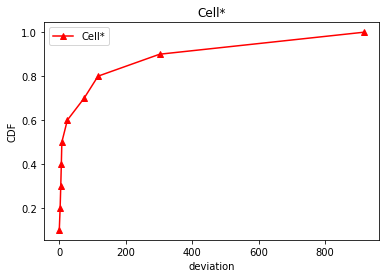

In [425]:
def plot_median(precision, xlabel, ylabel, title, n_count=10):
    precision = sorted(precision)
    def make_XY(precision, n_count):
        count = len(precision)
        step = int(count / n_count)
        X = [precision[i] for i in range(step-1,count,step)]
        Y = np.cumsum([1.0/n_count] * n_count)
        return X, Y
    X, Y = make_XY(precision, n_count)
    plt.plot(X, Y, 'r-^')
    plt.legend(['Cell*'], loc='best')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
plt.close('all')
plot_median(errors, 'deviation', 'CDF', 'Cell*')